In [13]:
import numpy as np
import s3fs
import datetime
import os
import netCDF4
import xarray as xr
import cartopy, cartopy.crs as ccrs
#from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [14]:
# Find Julian day from given year/month/day
def julian(year_name, month_name, day_name):
    
    calendar = datetime.datetime(year_name, month_name, day_name)
    julian_day = calendar.strftime('%j')
    
    return julian_day

In [15]:
# Create list of ABI data file names for given satellite/product and date/time period

def aws_list(year_name, month_name, day_name, starthour, startmin, endhour, endmin, satellite_name, view_name, sat_band, product):
    
    # Access AWS using anonymous credentials
    aws = s3fs.S3FileSystem(anon=True)
    
    # Make a list of all data files for given date and start/end hours
    julian_day = julian(year_name, month_name, day_name)
    hour_range = range(int(starthour), int(endhour) + 1)
    all_hours_list = []
    
    for i in hour_range:
        hour_files = aws.ls('noaa-goes' + str(satellite_name) + '/' + product + '/' + str(year_name) + '/' + julian_day + '/' + str(i) + '/', refresh=True)
        all_hours_list.extend(hour_files)
    
    # Extract list of data files for specified period set by start/end times
    data = []
    
    # List file names
    for i in all_hours_list:
        if view_name == 'CONUS': 

            # Select the files that are between the desired start and end time
            if i[-42:-38] >= (starthour + startmin) and i[-26:-22] <= (endhour + endmin):  

                # Account for the change in default scan mode of the ABI
                if i[-60:-57] == 'M3C' or i[-60:-57] == 'M6C':
                    
                    # Get desired band/channel
                    if i[-57:-55]  == sat_band:
                        data.append(i)
        else:
            continue

    return data

In [16]:
# Select satellite, ABI L1b product, view (only CONUS right now), band, and date & start/end times
satellite = 16
product_name = 'ABI-L1b-RadC'
view = 'CONUS'
year = 2019
month = 8
day = 22
start_hour = '15'
start_min = '00'
end_hour = '15'
end_min = '05'
band = '01'

In [17]:
# Select directory to save files, run code to list ABI data files, download files locally
# os.getcwd() + '/' saves files to current working directory

save_path = os.getcwd() + '/'  # directory where ABI data files will be saved

# Query AWS and list filenames matching entered settings
data = aws_list(year, month, day, start_hour, start_min, end_hour, end_min, satellite, view, band, product_name)
print('Available data files:\n', data)
print('\nData files will be saved to: ' + save_path)

if len(data) > 0:
    
    for i in data:
        filename = i.split('/')[-1]
        print(filename) 
        aws = s3fs.S3FileSystem(anon=True)
        for x in data:
            aws.get(x, save_path + x.split('/')[-1])
    print('Download complete!')

Available data files:
 ['noaa-goes16/ABI-L1b-RadC/2019/234/15/OR_ABI-L1b-RadC-M6C01_G16_s20192341501183_e20192341503556_c20192341504010.nc']

Data files will be saved to: C:\Users\margo/
OR_ABI-L1b-RadC-M6C01_G16_s20192341501183_e20192341503556_c20192341504010.nc
Download complete!


In [18]:
# Open the last GOES 16 image in the list using xarray
gs16 = netCDF4.Dataset(save_path + x.split('/')[-1], 'r')
store = xr.backends.NetCDF4DataStore(gs16)
ds = xr.open_dataset(store)

print(save_path + x.split('/')[-1])
ds

C:\Users\margo/OR_ABI-L1b-RadC-M6C01_G16_s20192341501183_e20192341503556_c20192341504010.nc


<xarray.Dataset>
Dimensions:                                           (band: 1, num_star_looks: 24, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5000, y: 3000)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.1013 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_id                                           (band) int8 ...
    band_wavelength                                   (band) float32 ...
    t_star_look                                       (num_star_looks) datetime64[ns] ...
    band_wavelength_star_look                         (num_star_looks) float32 ...
Dimensions without coordinates: band, num_star_looks, number_of_image_bounds, number_of_time_bounds
Data variables: (12/35)
    Rad                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    percent_uncorrectable_L0_errors                   float32 ...
    earth_sun_distance_anomaly_in_AU                  float32 ...
    algorithm_dynamic_input_data_container            int32 ...
    processing_parm_version_container                 int32 ...
    algorithm_product_version_container               int32 ...
    star_id                                           (num_star_looks) float32 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2019-08-22T15:04:01.0Z
    time_coverage_start:       2019-08-22T15:01:18.3Z
    time_coverage_end:         2019-08-22T15:03:55.6Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        d8fd1568-9f4b-474c-8e3b-d0f85bbabf80

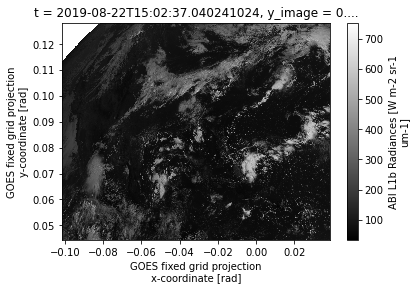

In [19]:
ds.Rad.plot(cmap='gray')

In [12]:
#fig = plt.figure(figsize=(12, 12))
#plt.imshow(ds.Rad, cmap='gray')